In [1]:
import torch
import math
import rich
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch   import nn
from termcolor import colored

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks  import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2023-11-16 15:54:34.138956: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-16 15:54:34.161008: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 15:54:34.215743: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-16 15:54:34.215775: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-16 15:54:34.215798: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
# define the device to use
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
rich.print(f"Device: [red]{DEVICE}")

Device: cpu

In [3]:
df = pd.read_csv('clean_data.csv')

# split the data
x = df['headline'].values
y = df['is_sarcastic'].values

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.20,
                                                    # shuffle = True,
                                                    random_state = 2456)

print(colored("\nDIVIDED SUCCESFULLY...", "green"))


DIVIDED SUCCESFULLY...


In [4]:
unique, counts = np.unique(y_train, return_counts=True)
print("Training set distribution:")
print(dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest set distribution:")
print(dict(zip(unique, counts)))

Training set distribution:
{0: 10173, 1: 9359}

Test set distribution:
{0: 2559, 1: 2324}


## tokenizing

In [5]:
unique_words = set()
len_max = 0

for sent in tqdm(x_train):
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
print(len(list(unique_words)))
print(len_max)

100%|██████████| 19532/19532 [00:00<00:00, 732614.45it/s]

39
911


In [6]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(x_train))

x_train = tokenizer.texts_to_sequences(x_train)
x_test  = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen=len_max)
x_test  = pad_sequences(x_test, maxlen=len_max)

print(x_train.shape, x_test.shape)

(19532, 911) (4883, 911)


In [7]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = "auto", 
                               verbose = 1, monitor = "val_acc",
                               patience = 3)
callbacks = [early_stopping]

## Model

In [11]:
model = Sequential()
model.add(Embedding(len(list(unique_words)), 100, input_length = len_max))
model.add(LSTM(64, dropout = 0.5, recurrent_dropout = 0.5, 
               return_sequences = False))
model.add(Dense(25, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))
model.compile(loss = "binary_crossentropy", 
              optimizer = Adam(learning_rate = 0.004),
              metrics = ["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 911, 100)          3900      
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_2 (Dense)             (None, 25)                1625      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 47791 (186.68 KB)
Trainable params: 47791 (186.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(19532, 911) (19532,)
(4883, 911) (4883,)


In [12]:
history = model.fit(x_train, y_train, 
                    epochs = 5, validation_data = (x_test, y_test), 
                    batch_size = 16, verbose = 1, 
                    callbacks = callbacks)

Epoch 1/5
1221/1221 [==============================] - 1412s 1s/step - loss: 0.5789 - accuracy: 0.6980 - val_loss: 0.5477 - val_accuracy: 0.7211
Epoch 2/5
1221/1221 [==============================] - ETA: 0s - loss: 0.5565 - accuracy: 0.7167

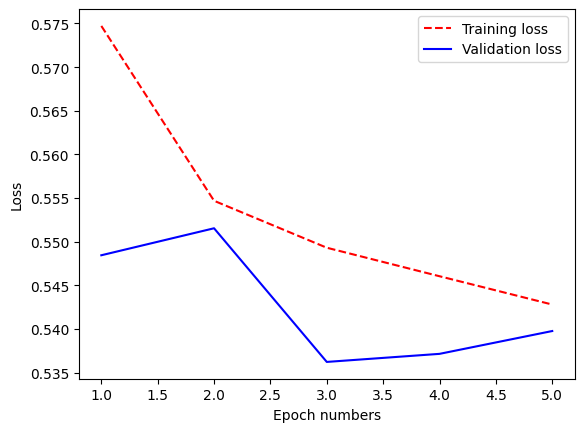

In [ ]:
epoch_num = range(1, len(history.history["loss"]) + 1)
plt.plot(epoch_num, history.history["loss"], "r--")
plt.plot(epoch_num, history.history["val_loss"], "b-")
plt.legend(["Training loss", "Validation loss"])
plt.xlabel("Epoch numbers")
plt.ylabel("Loss")
plt.show()

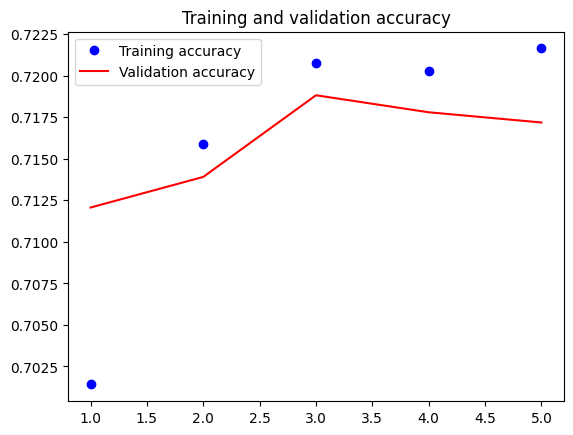

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()